In [1]:
# Import necessary libraries
import pandas as pd              # For data manipulation
import numpy as np               # For numerical operations
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns            # For advanced visualizations
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
from sklearn.naive_bayes import MultinomialNB  # For Naive Bayes model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # For evaluation

# Load dataset
from google.colab import files
uploaded = files.upload()

# Read the uploaded CSV file
import io
data = pd.read_csv(io.BytesIO(uploaded['tweet_emotions.csv']))

# Display the first few rows of the dataset
data.head()


Saving tweet_emotions.csv to tweet_emotions.csv


,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [2]:

# Import necessary libraries for text preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to clean the text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning to the 'content' column
data['cleaned_content'] = data['content'].apply(clean_text)

# Display the cleaned data
data[['content', 'cleaned_content']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,content,cleaned_content
0,@tiffanylue i know i was listenin to bad habi...,tiffanylue know listenin bad habit earlier sta...
1,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhhwaitin call
2,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,wants to hang out with friends SOON!,wants hang friends soon
4,@dannycastillo We want to trade with someone w...,dannycastillo want trade someone houston ticke...


In [3]:
# Step 1: Initialize and fit TF-IDF Vectorizer to create vocabulary
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Set max features and n-gram range
tfidf_vectorizer.fit(data['cleaned_content'])  # Fit on the full dataset to generate vocabulary

# Step 2: Define a function to check for invalid text based on the TF-IDF vocabulary
def is_invalid(text):
    words = text.split()
    # If text is empty or contains only stop words, consider it invalid
    if len(words) == 0 or all(word in stop_words for word in words):
        return "invalid"

    # Check if at least one word in the text is in the TF-IDF vectorizer vocabulary
    valid_words = [word for word in words if word in tfidf_vectorizer.vocabulary_]
    if len(valid_words) == 0:  # If no valid words are found
        return "invalid"

    return "valid"

# Step 3: Apply the invalid text function to check each row
data['text_validity'] = data['cleaned_content'].apply(is_invalid)

# Step 4: Filter out "invalid" entries
valid_data = data[data['text_validity'] == "valid"]

# Step 5: Transform valid data using the TF-IDF vectorizer
X = tfidf_vectorizer.transform(valid_data['cleaned_content'])
y = valid_data['sentiment']  # Labels for sentiment

# Display the shape of the transformed features
print("Feature matrix shape:", X.shape)

# Show some feature names
print("Sample feature names:", tfidf_vectorizer.get_feature_names_out()[:10])


Feature matrix shape: (39352, 5000)
Sample feature names: ['ability' 'able' 'able get' 'able go' 'absolutely' 'abt' 'ac' 'accept'
 'accepted' 'access']


In [4]:
# Display unique sentiments in the dataset
unique_sentiments = data['sentiment'].unique()
print("Unique sentiments:", unique_sentiments)


Unique sentiments: ['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [5]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression and SVM models
logistic_model = LogisticRegression(max_iter=200, random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)  # Use 'probability=True' for soft voting

# Combine Logistic Regression and SVM using Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[('logistic', logistic_model), ('svm', svm_model)],
    voting='soft'  # Soft voting to average probabilities
)

# Train the Voting Classifier on the training data
voting_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = voting_classifier.predict(X_test)

# Evaluate the model's performance
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Voting Classifier Accuracy: 0.33934696988946766

Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        20
     boredom       0.00      0.00      0.00        45
       empty       0.33      0.01      0.01       156
  enthusiasm       0.00      0.00      0.00       169
         fun       0.24      0.02      0.03       345
   happiness       0.34      0.36      0.35      1009
        hate       0.42      0.16      0.23       265
        love       0.47      0.36      0.41       738
     neutral       0.32      0.55      0.41      1690
      relief       0.55      0.04      0.08       290
     sadness       0.33      0.22      0.27      1002
    surprise       0.24      0.02      0.04       461
       worry       0.33      0.49      0.39      1681

    accuracy                           0.34      7871
   macro avg       0.27      0.17      0.17      7871
weighted avg       0.33      0.34      0.30      7871


Confu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
# Import libraries for model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier
nb_model = MultinomialNB()

# Train the model on the training data
nb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = nb_model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.3186380383686952


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        20
     boredom       0.00      0.00      0.00        45
       empty       0.00      0.00      0.00       156
  enthusiasm       0.00      0.00      0.00       169
         fun       0.00      0.00      0.00       345
   happiness       0.34      0.31      0.33      1009
        hate       0.25      0.00      0.01       265
        love       0.51      0.28      0.36       738
     neutral       0.30      0.52      0.38      1690
      relief       0.33      0.00      0.01       290
     sadness       0.32      0.15      0.20      1002
    surprise       0.00      0.00      0.00       461
       worry       0.30      0.57      0.40      1681

    accuracy                           0.32      7871
   macro avg       0.18      0.14      0.13      7871
weighted avg       0.28      0.32      0.27      7871


Confusion Matrix:
 [[  0   0   0   0   0   0   0   1 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=200, random_state=42)

# Train the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate the Logistic Regression model's performance
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Display confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:\n", conf_matrix_lr)


Logistic Regression Accuracy: 0.3370600940160081

Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        20
     boredom       0.00      0.00      0.00        45
       empty       0.25      0.01      0.01       156
  enthusiasm       0.00      0.00      0.00       169
         fun       0.25      0.03      0.06       345
   happiness       0.33      0.36      0.34      1009
        hate       0.40      0.14      0.20       265
        love       0.47      0.36      0.41       738
     neutral       0.33      0.53      0.40      1690
      relief       0.38      0.04      0.08       290
     sadness       0.32      0.26      0.28      1002
    surprise       0.21      0.03      0.05       461
       worry       0.33      0.47      0.39      1681

    accuracy                           0.34      7871
   macro avg       0.25      0.17      0.17      7871
weighted avg       0.32      0.34      0.30      7871


Conf

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


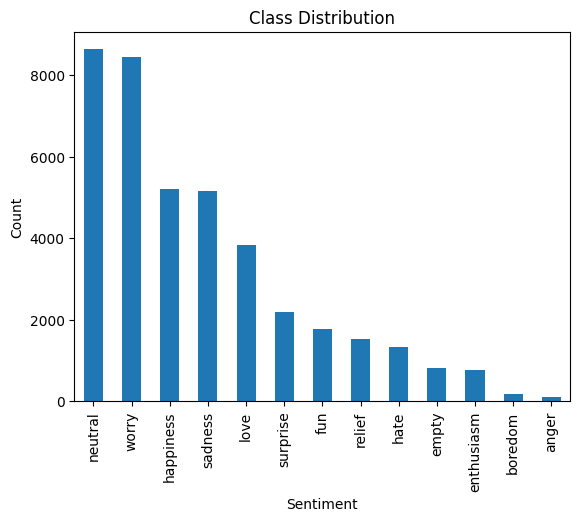

In [9]:
# Checking class distribution
import matplotlib.pyplot as plt

data['sentiment'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [10]:
import json

# Define quotes for each sentiment category
quotes_by_sentiment = {
    "empty": [
        "Sometimes, the emptiest spaces hold the most profound lessons.",
        "An empty cup is a sign that you are ready to fill it with something new.",
        "The greatest emptiness comes when there is no sense of purpose.",
        "In emptiness, there is room for growth and new beginnings.",
        "The silence of emptiness often speaks louder than words."
    ],
    "sadness": [
        "Tears come from the heart and not from the brain. - Leonardo da Vinci",
        "Sadness flies away on the wings of time. - Jean de La Fontaine",
        "Every human walks around with a certain kind of sadness. They may not wear it on their sleeves, but it's there if you look deep. - Taraji P. Henson",
        "The word ‘happy’ would lose its meaning if it were not balanced by sadness. - Carl Jung",
        "Sometimes, even to live is an act of courage. - Seneca"
    ],
    "enthusiasm": [
        "Enthusiasm moves the world.",
        "The more enthusiastic you are, the more you attract people to you.",
        "Enthusiasm is the mother of effort, and without it nothing great was ever achieved.",
        "Nothing great was ever achieved without enthusiasm.",
        "Enthusiasm is contagious. Make it your mission to spread it."
    ],
    "neutral": [
        "A calm and peaceful mind is the greatest treasure.",
        "Neutrality is not the absence of emotion, but the ability to balance emotions.",
        "A neutral stance helps you see things from all perspectives.",
        "The calm that neutrality brings helps one make clear decisions.",
        "Sometimes, neutrality is the best response in chaotic situations."
    ],
    "worry": [
        "Worry does not empty tomorrow of its sorrow, it empties today of its strength.",
        "Do not anticipate trouble, or worry about what may never happen. Keep in the sunlight.",
        "Worry is a misuse of the imagination.",
        "Worrying is like walking around with an umbrella, waiting for it to rain.",
        "Our fatigue is often caused not by work, but by worry."
    ],
    "surprise": [
        "Surprise is the greatest gift which life can grant us. - Boris Pasternak",
        "Life is full of surprises, some good, some not so good. - Pablo Escobar",
        "A story to me means a plot where there is some surprise. Because that is how life is—full of surprises. - Isaac Bashevis Singer",
        "The moments of happiness we enjoy take us by surprise. It is not that we seize them, but that they seize us. - Ashley Montagu",
        "The secret to humor is surprise. - Aristotle"
    ],
    "love": [
        "Love is composed of a single soul inhabiting two bodies. - Aristotle",
        "Where there is love there is life. - Mahatma Gandhi",
        "The best thing to hold onto in life is each other. - Audrey Hepburn",
        "Love is when the other person’s happiness is more important than your own. - H. Jackson Brown, Jr.",
        "Being deeply loved by someone gives you strength, while loving someone deeply gives you courage. - Lao Tzu"
    ],
    "fun": [
        "Fun is not a luxury, it’s a necessity for a happy life.",
        "Laughter is the shortest distance between two people.",
        "Life is too important to be taken seriously.",
        "The purpose of life is not just to survive, but to have fun while doing it.",
        "To live a fun life, you must first learn to enjoy the little things."
    ],
    "hate": [
        "Hate is the poison we drink hoping others will die.",
        "Hate is a blind, venomous force that takes away peace and joy.",
        "The best way to overcome hate is through love.",
        "Hate only breeds more hate; only love can dispel it.",
        "Hate makes us blind to the possibilities of peace."
    ],
    "happiness": [
        "Happiness is not something ready-made. It comes from your own actions. - Dalai Lama",
        "Happiness depends upon ourselves. - Aristotle",
        "The purpose of our lives is to be happy. - Dalai Lama",
        "Happiness radiates like the fragrance from a flower and draws all good things towards you. - Maharishi Mahesh Yogi",
        "The only joy in the world is to begin. - Cesare Pavese"
    ],
    "boredom": [
        "Boredom is the feeling that everything is a waste of time; serenity, that nothing is.",
        "The cure for boredom is curiosity. There is no cure for curiosity.",
        "Boredom is the greatest enemy of creativity.",
        "Boredom is the space where growth occurs, where creativity begins.",
        "Sometimes, boredom is the precursor to the most amazing adventures."
    ],
    "relief": [
        "Relief is the freedom of being able to breathe again after a long period of suffocating pressure.",
        "The greatest relief is when you let go of things you cannot control.",
        "Relief is the feeling when a burden is lifted from your shoulders.",
        "To be relieved of a worry is a true form of peace.",
        "Relief comes when you make peace with the things you cannot change."
    ],
    "anger": [
        "Anger is never without a reason, but seldom with a good one. - Benjamin Franklin",
        "For every minute you are angry you lose sixty seconds of happiness. - Ralph Waldo Emerson",
        "Holding on to anger is like grasping a hot coal with the intent of throwing it at someone else; you are the one who gets burned. - Buddha",
        "Anger and intolerance are the enemies of correct understanding. - Mahatma Gandhi",
        "Speak when you are angry and you will make the best speech you will ever regret. - Ambrose Bierce"
    ]

}

# Save quotes to a JSON file
with open("quotes_by_sentiment.json", "w") as file:
    json.dump(quotes_by_sentiment, file)


In [11]:
# Load the quotes file
with open("quotes_by_sentiment.json", "r") as file:
    quotes_by_sentiment = json.load(file)

# Function to get a random quote based on the sentiment
import random

def get_quote(sentiment):
    if sentiment in quotes_by_sentiment:
        return random.choice(quotes_by_sentiment[sentiment])
    return "No quotes available for this sentiment."


In [12]:
def predict_emotion_and_quote(text):
    # Clean the input text
    cleaned_text = clean_text(text)

    # Check if the text is valid
    if is_invalid(cleaned_text) == "invalid":
        return "Invalid input. Please enter meaningful text."
    else:
        # Vectorize the cleaned text
        transformed_text = tfidf_vectorizer.transform([cleaned_text])

        # Predict emotion using Naive Bayes model (or Logistic Regression as desired)
        predicted_emotion = lr_model.predict(transformed_text)[0]  # or use lr_model.predict(transformed_text)[0]

        # Get quote based on the predicted emotion
        quote = get_quote(predicted_emotion)

        # Return the result
        return f"Emotion: {predicted_emotion}\nQuote: {quote}"


In [13]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [14]:
import gradio as gr

# Define the Gradio interface function
def gradio_interface(text):
    return predict_emotion_and_quote(text)

# Create the Gradio interface
interface = gr.Interface(
    fn=gradio_interface,  # The function to call
    inputs="text",        # Input type
    outputs="text",       # Output type
    title="Emotion Prediction and Quotes generator",
    description="Enter a sentence to get the predicted emotion and a relevant quote. If the input is meaningless, 'invalid' will be displayed."
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1eeeee8e488c0c244c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
